In [37]:
import glob
import time
import numpy as np
import pandas as pd
from scipy.stats import norm, sem
from scipy.optimize import curve_fit
from matplotlib import pyplot as plt

In [229]:
files = glob.glob('data/Unidirectional/Combined/*.csv')
files.extend(glob.glob('data/Bidirectional/Combined/*.csv'))

In [3]:
bidirectional = glob.glob('data/Bidirectional/*.csv')

subjects = set()
for file in bidirectional:
    subjects.add(file[file.rfind('/')+1:][:3])

for subject in subjects:
    data = glob.glob(f'data/Bidirectional/*{subject}*_Adapt.csv')
    data = [pd.read_csv(d, index_col=0) for d in data]
    pd.concat(data).to_csv(f'data/Bidirectional/Combined/{subject}_Adapt.csv')

In [235]:
def f(x, m, s):
    return norm.cdf(x, m, s)

output = pd.DataFrame(columns=['Name', 'Exp Type', 'Mu', 'Sigma', 'Direction'])

for file in files:
    data = pd.read_csv(file, index_col=0)

    count_data = data.groupby('Test Speed')['Response'].apply(lambda x: x[x.str.contains('right')].count())
    total_counts = data.groupby('Test Speed').count()['Response']
    speeds = count_data.index.tolist()
    t = np.linspace(min(speeds), max(speeds), 1000)

    right_counts = count_data.tolist()
    right_props = [r / c for r, c in zip(right_counts, total_counts)]

    mu, sigma = curve_fit(f, speeds, right_props, p0=[0, 2], method='dogbox')[0]
    
    name = file[file.rfind('/')+1:][:3].upper()
    t_type = 'Unidirectional' if 'Unidirectional' in file else 'Bidirectional'
    if 'noAdapt' in file:
        t_type = 'No Adapt'
    elif 'practice' in file:
        t_type = 'Practice'
    else:
        t_type += ' Adapt'
    
    if 'noAdapt' in file or 'practice' in file:
        direction = ''
    elif 'Bidirectional' in file:
        direction = 0
    else:
        direction = -1 if min(speeds) < -40 else 1
        #print(f'{name}: {min(speeds)}, {max(speeds)}\t{direction}')
    
    output.loc[len(output)] = [name, t_type, mu, sigma, direction]
    
    if 'practice' in file:
        continue
    
    #plt.plot(speeds, right_props, alpha=.5, label='Subject')
    plt.figure(figsize=(8,6))
    plt.scatter(speeds, right_props, color='orange', label='Subject Data')
    plt.plot(t, norm.cdf(t, mu, sigma), alpha=.5, color='blue', label='Guassian Fit')
    plt.axhline(y=0.5, color='r', linewidth=0.5, linestyle='dashed')
    plt.axvline(x=0, color='r', linewidth=0.5, linestyle='dashed')
    plt.ylim(-0.05, 1.05)
    plt.xlabel('Test Stimulus Speed (deg/s)')
    plt.ylabel('Proportion of Responding Clockwise')
    plt.title(f'{name} ({t_type})')
    plt.legend(loc='lower right', framealpha=0.5)
    
    filename = file[file.rfind('/'):-4]
    plt.savefig(f'plots/{filename}.pdf')
    plt.close()

output = output.sort_values(['Name', 'Exp Type']).reset_index(drop=True)

NXN: -10.0, 70.0	1
KSM: -70.0, 10.0	-1
TEE: -70.0, 10.0	-1
SXK: -40.0, 70.0	1
MJL: -10.0, 70.0	1
JDG: -70.0, 10.0	-1
NST: -70.0, 10.0	-1
TXD: -10.0, 70.0	1
KXT: -10.0, 70.0	1
MXW: -70.0, 10.0	-1
ANB: -10.0, 70.0	1
NXS: -70.0, 10.0	-1


In [236]:
output.to_csv('GaussFitData.csv')

In [ ]:
for file in files:
    
    data = pd.read_csv(file, index_col=0)

    count_data = data.groupby('Test Speed')['Response'].apply(lambda x: x[x.str.contains('right')].count())
    total_counts = data.groupby('Test Speed').count()['Response']
    speeds = count_data.index.tolist()
    t = np.linspace(min(speeds), max(speeds), 1000)

    right_counts = count_data.tolist()
    right_props = [r / c for r, c in zip(right_counts, total_counts)]

    mu, sigma = curve_fit(f, speeds, right_props, p0=[0, 2], method='dogbox')[0]
    
    name = file[file.rfind('/')+1:][:3].upper()
    t_type = 'Unidirectional' if 'Unidirectional' in file else 'Bidirectional'
    if 'noAdapt' in file:
        t_type = 'No Adapt'
    elif 'practice' in file:
        t_type = 'Practice'
    else:
        t_type += ' Adapt'
    
    if 'noAdapt' in file or 'practice' in file:
        direction = ''
    elif 'Bidirectional' in file:
        direction = 0
    else:
        direction = -1 if min(speeds) < -40 else 1
        #print(f'{name}: {min(speeds)}, {max(speeds)}\t{direction}')
    
    output.loc[len(output)] = [name, t_type, mu, sigma, direction]
    
    if 'practice' in file:
        continue
    
    #plt.plot(speeds, right_props, alpha=.5, label='Subject')
    plt.figure(figsize=(8,6))
    plt.scatter(speeds, right_props, color='orange', label='Subject Data')
    plt.plot(t, norm.cdf(t, mu, sigma), alpha=.5, color='blue', label='Guassian Fit')
    plt.axhline(y=0.5, color='r', linewidth=0.5, linestyle='dashed')
    plt.axvline(x=0, color='r', linewidth=0.5, linestyle='dashed')
    plt.ylim(-0.05, 1.05)
    plt.xlabel('Test Stimulus Speed (deg/s)')
    plt.ylabel('Proportion of Responding Clockwise')
    plt.title(f'{name} ({t_type})')
    plt.legend(loc='lower right', framealpha=0.5)
    
    filename = file[file.rfind('/'):-4]
    plt.savefig(f'plots/{filename}.pdf')
    plt.close()

output = output.sort_values(['Name', 'Exp Type']).reset_index(drop=True)

No Adapt Stats
[0.14375    0.20416667 0.19791667 0.19791667 0.28958333 0.51458333
 0.72083333 0.77708333 0.80833333 0.83958333 0.86666667]
[0.02134781 0.02800726 0.02270912 0.01753199 0.02392743 0.02546134
 0.01917655 0.02005162 0.03082412 0.02583058 0.0211715 ]
Adapt Stats
[0.04791667 0.05       0.06041667 0.08645833 0.128125   0.478125
 0.86041667 0.94375    0.94375    0.95729167 0.95520833]
[0.01677286 0.016855   0.02532148 0.02801254 0.02076456 0.03264409
 0.0225522  0.01979416 0.01887584 0.01565023 0.01638914]


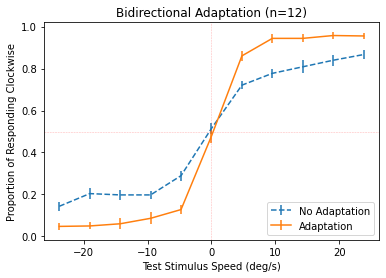

In [76]:
files = glob.glob('data/Bidirectional/*.csv')
files = [f for f in files if '_practice' not in f]
files.sort()

files_noadapt = []
files_adapt = []
for subject in subjects:
    tmp = [f for f in files if subject in f]

    files_noadapt.append(tmp[0])
    files_adapt += tmp[1:-1]
    assert('_noAdapt' in tmp[0])
    assert('_Adapt' in tmp[1])
    assert('_Adapt' in tmp[2])

speeds_noadapt, props_noadapt = [], []
for f in files_noadapt:
    data = pd.read_csv(f, index_col=0)
    count_data = data.groupby('Test Speed')['Response'].apply(lambda x: x[x.str.contains('right')].count())
    total_counts = data.groupby('Test Speed').count()['Response']
    speeds_noadapt = count_data.index.tolist()

    right_counts = count_data.tolist()
    right_props = [r / c for r, c in zip(right_counts, total_counts)]
    props_noadapt.append(right_props)

speeds_adapt, props_adapt = [], []
for subject in subjects:
    dfs = [pd.read_csv(f, index_col=0) for f in files_adapt if subject in f[f.rfind('/'):]]
    data = pd.concat(dfs, axis=0)
    count_data = data.groupby('Test Speed')['Response'].apply(lambda x: x[x.str.contains('right')].count())
    total_counts = data.groupby('Test Speed').count()['Response']

    speeds_adapt = count_data.index.tolist()

    right_counts = count_data.tolist()
    right_props = [r / c for r, c in zip(right_counts, total_counts)]
    props_adapt.append(right_props)

speeds_adapt = [s*0.595 for s in speeds_adapt]
speeds_noadapt = [s*0.595 for s in speeds_noadapt]
props_avg_noadapt = np.mean(props_noadapt, axis=0)
props_avg_adapt = np.mean(props_adapt, axis=0)

print("No Adapt Stats")
print("==============")
print(props_avg_noadapt)
print(sem(props_noadapt, axis=0))

print("Adapt Stats")
print("===========")
print(props_avg_adapt)
print(sem(props_adapt, axis=0))

plt.clf()
plt.errorbar(speeds_adapt, props_avg_noadapt, yerr=sem(props_noadapt, axis=0), linestyle='dashed', label='No Adaptation')
plt.errorbar(speeds_noadapt, props_avg_adapt, yerr=sem(props_adapt, axis=0), label='Adaptation')

plt.axhline(y=0.5, color='r', linewidth=0.5, linestyle='dashed', alpha=0.3)
plt.axvline(x=0, color='r', linewidth=0.5, linestyle='dashed', alpha=0.3)
plt.title(f'Bidirectional Adaptation (n=12)')
plt.xlabel('Test Stimulus Speed (deg/s)')
plt.ylabel('Proportion of Responding Clockwise')
plt.legend(loc='lower right')
plt.savefig(f'plots/average_bidirectional.svg')

No Adapt Stats
[0.1625     0.175      0.19791667 0.2125     0.30208333 0.55416667
 0.75833333 0.80625    0.81458333 0.87708333 0.87916667]
[0.02333469 0.0246183  0.01933025 0.02229706 0.02894259 0.02608141
 0.01880254 0.01689007 0.02619463 0.02392743 0.01533506]
Adapt Stats
[0.7291666666666666, 0.6708333333333334, 0.65, 0.5958333333333333, 0.45416666666666666, 0.3583333333333334, 0.25416666666666665, 0.17500000000000002, 0.7999999999999999, 0.12083333333333335, 0.8166666666666665, 0.075, 0.7333333333333334, 0.041666666666666664, 0.6750000000000002, 0.6166666666666667, 0.6, 0.5, 0.44166666666666665, 0.3708333333333334, 0.38749999999999996, 0.3125]
[0.01677286 0.016855   0.02532148 0.02801254 0.02076456 0.03264409
 0.0225522  0.01979416 0.01887584 0.01565023 0.01638914]


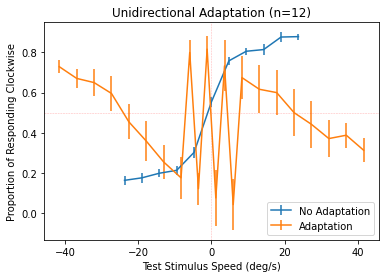

In [118]:
files = glob.glob('data/Bidirectional/*.csv')
files = [f for f in files if '_practice' not in f]
files.sort()

files_noadapt = []
files_adapt = glob.glob('data/Unidirectional/*.csv')
for subject in subjects:
    tmp = [f for f in files if subject in f]
    files_noadapt.append(tmp[-1])
    assert('_noAdapt' in tmp[0])

speeds_noadapt, props_noadapt = [], []
for f in files_noadapt:
    data = pd.read_csv(f, index_col=0)
    count_data = data.groupby('Test Speed')['Response'].apply(lambda x: x[x.str.contains('right')].count())
    total_counts = data.groupby('Test Speed').count()['Response']
    speeds_noadapt = count_data.index.tolist()

    right_counts = count_data.tolist()
    right_props = [r / c for r, c in zip(right_counts, total_counts)]
    props_noadapt.append(right_props)

adapt_data = dict()
for f in files_adapt:
    data = pd.read_csv(f, index_col=0)
    count_data = data.groupby('Test Speed')['Response'].apply(lambda x: x[x.str.contains('right')].count())
    total_counts = data.groupby('Test Speed').count()['Response']
    speeds = count_data.index.tolist()

    right_counts = count_data.tolist()
    right_props = [r / c for r, c in zip(right_counts, total_counts)]

    for speed, prop in zip(speeds, right_props):
        if -speed not in adapt_data.keys():
            adapt_data[-speed] = []
        adapt_data[-speed].append(prop)

speeds_noadapt = [s*0.595 for s in speeds_noadapt]
speeds_adapt = [s*0.595 for s in adapt_data.keys()]

props_avg_noadapt = np.mean(props_noadapt, axis=0)
props_avg_adapt = [np.mean(p) for p in adapt_data.values()]
props_avg_adapt = [x for _,x in sorted(zip(speeds_adapt, props_avg_adapt))]
speeds_adapt.sort()

print("No Adapt Stats")
print("==============")
print(props_avg_noadapt)
print(sem(props_noadapt, axis=0))

print("Adapt Stats")
print("===========")
print(props_avg_adapt)
print(sem(props_adapt, axis=0))

plt.clf()
#plt.scatter(speeds, props_avg_noadapt, label='No Adaptation', edgecolors='black', facecolors='none', marker='s')
#plt.scatter(speeds, props_avg_adapt, label='Adaptation', edgecolors='black', facecolors='none', marker='^')
plt.errorbar(speeds_noadapt, props_avg_noadapt, yerr=sem(props_noadapt, axis=0), label='No Adaptation')
plt.errorbar(speeds_adapt, props_avg_adapt, yerr=[sem(p) for p in adapt_data.values()], label='Adaptation')

plt.axhline(y=0.5, color='r', linewidth=0.5, linestyle='dashed', alpha=0.3)
plt.axvline(x=0, color='r', linewidth=0.5, linestyle='dashed', alpha=0.3)
plt.title(f'Unidirectional Adaptation (n=12)')
plt.xlabel('Test Stimulus Speed (deg/s)')
plt.ylabel('Proportion of Responding Clockwise')
plt.legend(loc='lower right')
plt.savefig(f'newplots/average_2b.svg')

No Adapt Stats
[0.1625     0.175      0.19791667 0.2125     0.30208333 0.55416667
 0.75833333 0.80625    0.81458333 0.87708333 0.87916667]
[0.02333469 0.0246183  0.01933025 0.02229706 0.02894259 0.02608141
 0.01880254 0.01689007 0.02619463 0.02392743 0.01533506]
Adapt1 Stats
[0.12083333 0.12916667 0.19375    0.25       0.31875    0.37916667
 0.47708333 0.57708333 0.63958333 0.64166667 0.70833333]
[0.04022114 0.04103691 0.05823517 0.07295183 0.07165026 0.07261572
 0.07027128 0.07200184 0.06738193 0.07212503 0.07297346]


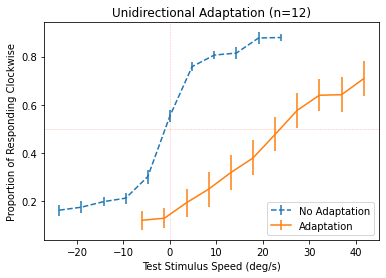

In [127]:
files = glob.glob('data/Bidirectional/*.csv')
files = [f for f in files if '_practice' not in f]
files.sort()

files_noadapt = []
files_adapt = glob.glob('data/Unidirectional/*.csv')
for subject in subjects:
    tmp = [f for f in files if subject in f]
    files_noadapt.append(tmp[-1])
    assert('_noAdapt' in tmp[0])

speeds_noadapt, props_noadapt = [], []
for f in files_noadapt:
    data = pd.read_csv(f, index_col=0)
    count_data = data.groupby('Test Speed')['Response'].apply(lambda x: x[x.str.contains('right')].count())
    total_counts = data.groupby('Test Speed').count()['Response']
    speeds_noadapt = count_data.index.tolist()

    right_counts = count_data.tolist()
    right_props = [r / c for r, c in zip(right_counts, total_counts)]
    props_noadapt.append(right_props)

speeds_adapt_1, speeds_adapt_2 = [], []
props_adapt_1, props_adapt_2 = [], []
for f in files_adapt:
    data = pd.read_csv(f, index_col=0)
    count_data = data.groupby('Test Speed')['Response'].apply(lambda x: x[x.str.contains('right')].count())
    total_counts = data.groupby('Test Speed').count()['Response']
    speeds = count_data.index.tolist()

    right_counts = count_data.tolist()
    right_props = [r / c for r, c in zip(right_counts, total_counts)]
    if speeds_adapt_1 == [] or speeds == speeds_adapt_1:
        speeds_adapt_1 = speeds
        props_adapt_1.append(right_props)
    else:
        speeds_adapt_2 = [-s for s in speeds]
        props_adapt_1.append([1-p for p in right_props][::-1])

speeds_noadapt = [s*0.595 for s in speeds_noadapt]
speeds_adapt_1 = [s*0.595 for s in speeds_adapt_1]
speeds_adapt_2 = [s*0.595 for s in speeds_adapt_2]

props_avg_noadapt = np.mean(props_noadapt, axis=0)
props_avg_adapt_1 = np.mean(props_adapt_1, axis=0)

print("No Adapt Stats")
print("==============")
print(props_avg_noadapt)
print(sem(props_noadapt, axis=0))

print("Adapt1 Stats")
print("============")
print(props_avg_adapt_1)
print(sem(props_adapt_1, axis=0))

plt.clf()
plt.errorbar(speeds_noadapt, props_avg_noadapt, yerr=sem(props_noadapt, axis=0), linestyle='dashed', label='No Adaptation')
plt.errorbar(speeds_adapt_1, props_avg_adapt_1, yerr=sem(props_adapt_1, axis=0), label='Adaptation')
plt.axhline(y=0.5, color='r', linewidth=0.5, linestyle='dashed', alpha=0.3)
plt.axvline(x=0, color='r', linewidth=0.5, linestyle='dashed', alpha=0.3)
plt.title(f'Unidirectional Adaptation (n=12)')
plt.xlabel('Test Stimulus Speed (deg/s)')
plt.ylabel('Proportion of Responding Clockwise')
plt.legend(loc='lower right')
plt.savefig(f'plots/average_unidirectional.svg')